In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import os
import sys
import glob
#from sklearn.decomposition import PCA
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.anova import AnovaRM
import pingouin as pg


In [2]:
#writer = pd.ExcelWriter('Boris_Data.xlsx')

In [78]:
cheatsheet = pd.read_excel("BORIS_match_mastersheet.xlsx")
df = cheatsheet.set_index('Observation ID ')
df = df[['Match', 'Pilot', 'Day', 'Scorer',
       'Trial Length ', 'Winner ID', 'Winner Rank', 'Loser ID', 'Loser Rank']]
df['Winner ID'] = df['Pilot'].astype(str) + '.' + df['Winner ID'].astype(str)
df['Loser ID'] = df['Pilot'].astype(str) + '.' + df['Loser ID'].astype(str)

df = df.fillna(0)
df
cheatsheet_dict=df.to_dict('index')

In [79]:
def get_specbetter(filename, cheatsheet, scorer): 
    boris_observation = pd.read_excel(filename)
    overview = {}
    
    for subject in boris_observation['Subject'].unique():
        if len(boris_observation['Subject'].unique()) == 1:
            print(filename)
        event_specs = {}
        event_specs.update(cheatsheet[boris_observation['Observation id'][0]])
        if event_specs['Winner ID'] == subject:
            event_specs['Rank'] = event_specs['Winner Rank']
        else:
            event_specs['Rank'] = event_specs['Loser Rank']
        if event_specs['Trial Length '] == 0:
            event_specs['Trial Length '] = boris_observation['Media duration (s)'][0]
        for behavior in boris_observation['Behavior'].unique():
            behavior_df = boris_observation[(boris_observation['Behavior'] == behavior) & (boris_observation['Subject'] == subject)]
            behavior_df = behavior_df[['Behavior type','Time']]
            behavior_py = behavior_df.to_numpy()
            events = []
            for i in range(0, len(behavior_py)-1, 2):
                events.append(abs(behavior_py[i][1] - behavior_py[i+1][1]))
            if len(events) == 0:
                event_specs[behavior + ' Total time'] = 0
                event_specs[behavior + ' % Time'] = 0
                event_specs[behavior + ' Number of events'] = 0
                event_specs[behavior + ' Average Length of Bout'] = 0
            else:
                event_specs[behavior + ' Total time'] = sum(events)
                event_specs[behavior + ' % Time'] = sum(events) / event_specs['Trial Length ']
                event_specs[behavior + ' Number of events'] = len(events)
                event_specs[behavior + ' Average Length of Bout'] = sum(events)/len(events)
            
        event_specs['observation_ID'] = boris_observation['Observation id'][0]
        event_specs['Scorer'] = scorer[2:]
        
        if subject[2] in ['1', '2', '3']:
            event_specs['Strain'] = 'C57'
        else:
            event_specs['Strain'] = 'CD1'
        overview[subject] = event_specs
        
    overview_df = pd.DataFrame.from_dict(overview,
                                      orient = 'index')
    return overview_df

In [80]:
first_file = True 
for person in glob.glob('.\\*'):
    if os.path.isdir(person):   
        for file in glob.glob(".\\"+person+"\\*.xlsx"):
            if first_file:
                master_df = pd.read_excel(file)
                first_file = False
            else:
                master_df = pd.concat([pd.read_excel(file), master_df])
master_df.to_excel('boris_data_master.xlsx', index=True)

In [95]:
def who_is_opponent(winner_id, loser_id, subject):
    if winner_id == subject:
        opponent = loser_id
    else:
        opponent = winner_id
    return opponent
person_df_lst = []
first_file = True 
for person in glob.glob('.\\*'):
    if os.path.isdir(person):   
        for file in glob.glob(".\\"+person+"\\*.xlsx"):
            if first_file:
                master_df = get_specbetter(file, cheatsheet_dict, person)
                first_file = False
            else:
                master_df = pd.concat([get_specbetter(file, cheatsheet_dict, person), master_df])
master_df = master_df.fillna(0)        
master_df = master_df.reset_index()
master_df = master_df.rename(columns={'index': 'Subject'})
master_df['Is winner'] = master_df['Winner ID'] == master_df['Subject']
master_df['Is loser'] = master_df['Loser ID'] == master_df['Subject']
master_df['Rank Difference'] = master_df['Winner Rank'] - master_df['Loser Rank'] 
master_df['Opponent'] = master_df.apply(lambda row: who_is_opponent(row['Winner ID'], row['Loser ID'], row['Subject']), axis = 1)
master_df
#master_df.to_excel(writer, sheet_name = 'Data', index=True)

.\.\Aidan\pilot2_D4_C3_1v2.xlsx
.\.\Aidan\pilot2_D4_C4_2v3.xlsx
.\.\Amelia\2_2.1v2.3.xlsx
.\.\Amelia\2_4.2v4.1.xlsx
.\.\Catalina\2_4.1vs4.2_Catalina.xlsx
.\.\Ezra\Cage4_3v4_20220714.xlsx
.\.\Jocelyn\2_3.1vs3.3.xlsx
.\.\Jocelyn\3_3.1vs3.3.xlsx


,Subject,Match,Pilot,Day,Scorer,Trial Length,Winner ID,Winner Rank,Loser ID,Loser Rank,...,Retreat (passive) Total time,Retreat (passive) % Time,Retreat (passive) Number of events,Retreat (passive) Average Length of Bout,observation_ID,Strain,Is winner,Is loser,Rank Difference,Opponent
0,3.6.1,6.1 vs 6.3,3,1,Naeliz,17.00000,3.6.3,3,3.6.1,1,...,0.000,0.000000,0.0,0.0000,P3_Cage6_tubetest_1v3_D1_naeliz,CD1,False,True,2,3.6.3
1,3.6.3,6.1 vs 6.3,3,1,Naeliz,17.00000,3.6.3,3,3.6.1,1,...,0.999,0.058765,1.0,0.9990,P3_Cage6_tubetest_1v3_D1_naeliz,CD1,True,False,2,3.6.1
2,3.6.1,6.1 vs 6.2,3,stable,Naeliz,52.00000,3.6.1,1,3.6.2,2,...,0.674,0.012962,2.0,0.3370,P3_Cage6_tubetest_1v2_SD_naeliz,CD1,True,False,-1,3.6.2
3,3.6.2,6.1 vs 6.2,3,stable,Naeliz,52.00000,3.6.1,1,3.6.2,2,...,0.000,0.000000,0.0,0.0000,P3_Cage6_tubetest_1v2_SD_naeliz,CD1,False,True,-1,3.6.1
4,3.5.1,5.4 vs 5.1,3,1,Naeliz,13.00000,3.5.4,1,3.5.1,2,...,0.775,0.059615,1.0,0.7750,P3_Cage5_tubetest_4v1_D1_naeliz,CD1,False,True,-1,3.5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2.3.4,3.3 vs 3.4,2,1,Aidan,12.06667,2.3.3,3,2.3.4,2,...,1.807,0.149751,1.0,1.8070,pilot2_D1_C3_3v4,C57,False,True,1,2.3.3
276,2.2.4,2.4 vs 2.2,2,1,Aidan,21.63333,2.2.4,3,2.2.2,1,...,0.000,0.000000,0.0,0.0000,pilot2_D1_C2_2v4,C57,True,False,2,2.2.2
277,2.2.2,2.4 vs 2.2,2,1,Aidan,21.63333,2.2.4,3,2.2.2,1,...,5.343,0.246980,6.0,0.8905,pilot2_D1_C2_2v4,C57,False,True,2,2.2.4
278,3.4.4,4.3 vs 4.4,3,1,Aidan,10.48900,3.4.3,2,3.4.4,4,...,0.000,0.000000,0.0,0.0000,cage4_3v4,CD1,False,True,-2,3.4.3


In [123]:
master_df['Day'].replace('stable', 'not 1', inplace = True)
master_df['Day'].replace(4, 'not 1', inplace = True)

In [124]:
master_df['Outcome'] = pd.Categorical(master_df['Is winner'])
master_df['Strain'] = pd.Categorical(master_df['Strain'])
master_df['Day'] = pd.Categorical(master_df['Day'])
master_df['Subject'] = pd.Categorical(master_df['Subject'])
master_df['Opponent'] = pd.Categorical(master_df['Opponent'])
master_df['passive_retreat_percent'] = master_df['Retreat (passive) % Time']
master_df['retreat_percent'] = master_df['Retreat (in contact) % Time']
master_df['push_percent'] = master_df['Push % Time']
master_df['resist_percent'] = master_df['Resist % Time']
master_df


,Subject,Match,Pilot,Day,Scorer,Trial Length,Winner ID,Winner Rank,Loser ID,Loser Rank,...,Strain,Is winner,Is loser,Rank Difference,Opponent,Outcome,passive_retreat_percent,retreat_percent,push_percent,resist_percent
0,3.6.1,6.1 vs 6.3,3,1,Naeliz,17.00000,3.6.3,3,3.6.1,1,...,CD1,False,True,2,3.6.3,False,0.000000,0.255059,0.117706,0.205588
1,3.6.3,6.1 vs 6.3,3,1,Naeliz,17.00000,3.6.3,3,3.6.1,1,...,CD1,True,False,2,3.6.1,True,0.058765,0.014706,0.514059,0.073647
2,3.6.1,6.1 vs 6.2,3,not 1,Naeliz,52.00000,3.6.1,1,3.6.2,2,...,CD1,True,False,-1,3.6.2,True,0.012962,0.009558,0.115308,0.009635
3,3.6.2,6.1 vs 6.2,3,not 1,Naeliz,52.00000,3.6.1,1,3.6.2,2,...,CD1,False,True,-1,3.6.1,False,0.000000,0.000000,0.043269,0.115385
4,3.5.1,5.4 vs 5.1,3,1,Naeliz,13.00000,3.5.4,1,3.5.1,2,...,CD1,False,True,-1,3.5.4,False,0.059615,0.000000,0.173154,0.249923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2.3.4,3.3 vs 3.4,2,1,Aidan,12.06667,2.3.3,3,2.3.4,2,...,C57,False,True,1,2.3.3,False,0.149751,0.165746,0.576795,0.181492
276,2.2.4,2.4 vs 2.2,2,1,Aidan,21.63333,2.2.4,3,2.2.2,1,...,C57,True,False,2,2.2.2,True,0.000000,0.000000,0.141957,0.280262
277,2.2.2,2.4 vs 2.2,2,1,Aidan,21.63333,2.2.4,3,2.2.2,1,...,C57,False,True,2,2.2.4,False,0.246980,0.053945,0.344653,0.013313
278,3.4.4,4.3 vs 4.4,3,1,Aidan,10.48900,3.4.3,2,3.4.4,4,...,CD1,False,True,-2,3.4.3,False,0.000000,0.169606,0.349318,0.223949


In [179]:
master_df.to_excel('boris_tubetest.xlsx')

In [175]:
anova = pg.mixed_anova(dv='retreat_percent', between ='Strain', subject='Subject', within = 'Outcome', data=master_df)
anova


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Strain,0.007796,1,31,0.007796,2.186493,1.493161e-01,0.065885,NaN
1,Outcome,0.121733,1,31,0.121733,44.723826,1.763574e-07,0.590618,1.0
2,Interaction,0.002784,1,31,0.002784,1.022829,3.196779e-01,0.031941,NaN


In [176]:
anova = pg.mixed_anova(dv='retreat_percent', between ='Strain', subject='Subject', within = 'Outcome', data=day1_df)
anova


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Strain,0.002244,1,25,0.002244,0.439297,0.513527,0.017268,NaN
1,Outcome,0.064501,1,25,0.064501,12.594836,0.001561,0.335015,1.0
2,Interaction,0.000213,1,25,0.000213,0.041677,0.839889,0.001664,NaN


In [142]:
model = mixedlm('passive_retreat_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())

model = mixedlm('retreat_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())

model = mixedlm('push_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())

model = mixedlm('resist_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())



c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      passive_retreat_percent
No. Observations:       280          Method:                  REML                   
No. Groups:             48           Scale:                   0.0120                 
Min. group size:        4            Log-Likelihood:          184.6001               
Max. group size:        6            Converged:               Yes                    
Mean group size:        5.8                                                          
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.094    0.022  4.333 0.000  0.052  0.137
Outcome[T.True]                            -0.085    0.029 -2.984 0.003 -0.141

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [163]:
import inspect
assigned_attributes = {attr: value for attr, value in vars(result).items() if value is not None}
methods = []
for attr in dir(result):
    try:
        if inspect.ismethod(getattr(result, attr)):
            methods.append(attr)
    except AttributeError:
        pass

methods


['__dir__',
 '__getattribute__',
 '__getstate__',
 '__init__',
 '_expand_re_names',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_transform_predict_exog',
 'bootstrap',
 'conf_int',
 'cov_params',
 'f_test',
 'get_nlfun',
 'initialize',
 'load',
 'predict',
 'profile_re',
 'remove_data',
 'save',
 'summary',
 't_test',
 't_test_pairwise',
 'wald_test',
 'wald_test_terms']

In [ ]:
result.f_test()

In [150]:
print(result.bic)

nan


In [127]:
anova_table = AnovaRM(master_df, 'passive_retreat_percent', 'Subject', within =['Outcome', 'Strain', 'Day'], aggregate_func='mean').fit()
print(anova_table)

TypeError: argument of type 'NoneType' is not iterable

In [165]:
pilot3_df= master_df[master_df['Pilot'] == 3]
pilot2_df= master_df[master_df['Pilot'] == 2]
day1_df = master_df[master_df['Day'] == 1]

In [178]:
anova = pg.mixed_anova(dv='retreat_percent', between ='Strain', subject='Subject', within = 'Outcome', data=day1_df)
print('Retreat')
print(anova)
anova = pg.mixed_anova(dv='resist_percent', between ='Strain', subject='Subject', within = 'Outcome', data=day1_df)
print('Resist')
print(anova)
anova = pg.mixed_anova(dv='passive_retreat_percent', between ='Strain', subject='Subject', within = 'Outcome', data=day1_df)
print('passive retreat')
print(anova)
anova = pg.mixed_anova(dv='push_percent', between ='Strain', subject='Subject', within = 'Outcome', data=day1_df)
print('push')
print(anova)



Retreat
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0       Strain  0.002244    1   25  0.002244   0.439297  0.513527  0.017268   
1      Outcome  0.064501    1   25  0.064501  12.594836  0.001561  0.335015   
2  Interaction  0.000213    1   25  0.000213   0.041677  0.839889  0.001664   

   eps  
0  NaN  
1  1.0  
2  NaN  
Resist
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0       Strain  0.179611    1   25  0.179611  8.711688  0.006781  0.258417   
1      Outcome  0.046651    1   25  0.046651  3.430224  0.075858  0.120654   
2  Interaction  0.009277    1   25  0.009277  0.682161  0.416656  0.026562   

   eps  
0  NaN  
1  1.0  
2  NaN  
passive retreat
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0       Strain  0.020772    1   25  0.020772  12.138962  0.001837  0.326852   
1      Outcome  0.068689    1   25  0.068689  39.440916  0.000001  0.612048   
2  Interaction  0.015026    1 

In [173]:

model = mixedlm('passive_retreat_percent ~ Outcome * Strain', data=day1_df, groups = day1_df['Subject'])
result = model.fit()
print(result.summary())
model = mixedlm('retreat_percent ~ Outcome * Strain', data=day1_df, groups = day1_df['Subject'])
result = model.fit()
print(result.summary())
model = mixedlm('push_percent ~ Outcome * Strain', data=day1_df, groups = day1_df['Subject'])
result = model.fit()
print(result.summary())
model = mixedlm('resist_percent ~ Outcome * Strain', data=day1_df, groups = day1_df['Subject'])
result = model.fit()
print(result.summary())

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  passive_retreat_percent
No. Observations:  141      Method:              REML                   
No. Groups:        48       Scale:               0.0044                 
Min. group size:   2        Log-Likelihood:      170.0833               
Max. group size:   3        Converged:           Yes                    
Mean group size:   2.9                                                  
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.098    0.011  8.607 0.000  0.075  0.120
Outcome[T.True]               -0.093    0.016 -5.809 0.000 -0.124 -0.062
Strain[T.CD1]                 -0.026    0.016 -1.609 0.108 -0.058  0.006
Outcome[T.True]:Strain[T.CD1]  0.026    0.023  1.101 0.271 -0.020  0.

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [174]:
print('Passive Retreat')
model = mixedlm('passive_retreat_percent ~ Outcome * Strain * Day', data=pilot3_df, groups = pilot3_df['Subject'])
result = model.fit()
print(result.summary())
print('Retreat')
model = mixedlm('retreat_percent ~ Outcome * Strain * Day', data=pilot3_df, groups = pilot3_df['Subject'])
result = model.fit()
print(result.summary())

print('Push')
model = mixedlm('push_percent ~ Outcome * Strain * Day', data=pilot3_df, groups = pilot3_df['Subject'])
result = model.fit()
print(result.summary())

print('Resist')
model = mixedlm('retreat_percent ~ Outcome * Strain * Day', data=pilot3_df, groups = pilot3_df['Subject'])
result = model.fit()
print(result.summary())

Passive Retreat
                        Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      passive_retreat_percent
No. Observations:       143          Method:                  REML                   
No. Groups:             24           Scale:                   0.0105                 
Min. group size:        5            Log-Likelihood:          100.8914               
Max. group size:        6            Converged:               Yes                    
Mean group size:        6.0                                                          
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.109    0.026  4.202 0.000  0.058  0.160
Outcome[T.True]                            -0.098    0.036 -2.

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         retreat_percent
No. Observations:         143             Method:                     REML           
No. Groups:               24              Scale:                      0.0104         
Min. group size:          5               Log-Likelihood:             102.5860       
Max. group size:          6               Converged:                  Yes            
Mean group size:          6.0                                                        
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.048    0.025  1.910 0.056 -0.001  0.097
Outcome[T.True]                            -0.031    0.035 -0.885 0.376 -0.100

In [171]:

model = mixedlm('passive_retreat_percent ~ Outcome * Strain * Day', data=pilot2_df, groups = pilot2_df['Subject'])
result = model.fit()
print(result.summary())


                        Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      passive_retreat_percent
No. Observations:       137          Method:                  REML                   
No. Groups:             24           Scale:                   0.0133                 
Min. group size:        4            Log-Likelihood:          73.4558                
Max. group size:        6            Converged:               Yes                    
Mean group size:        5.7                                                          
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.081    0.035  2.339 0.019  0.013  0.149
Outcome[T.True]                            -0.078    0.044 -1.792 0.073 -0.163

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


LinAlgError: Singular matrix

In [75]:
model = mixedlm('retreat_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())

LinAlgError: Singular matrix

In [40]:
model = mixedlm('resist_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())

                        Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         resist_percent
No. Observations:           280             Method:                     REML          
No. Groups:                 48              Scale:                      0.0162        
Min. group size:            4               Log-Likelihood:             136.1985      
Max. group size:            6               Converged:                  Yes           
Mean group size:            5.8                                                       
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.092    0.026  3.611 0.000  0.042  0.143
Outcome[T.True]                             -0.011    0.033 -0.327 0

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [41]:
model = mixedlm('push_percent ~ Outcome * Strain * Day', data=master_df, groups = master_df['Subject'])
result = model.fit()
print(result.summary())

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          push_percent
No. Observations:           280              Method:                      REML        
No. Groups:                 48               Scale:                       0.0259      
Min. group size:            4                Log-Likelihood:              70.7824     
Max. group size:            6                Converged:                   Yes         
Mean group size:            5.8                                                       
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.137    0.033  4.128 0.000  0.072  0.202
Outcome[T.True]                              0.078    0.043  1.837 0

c:\Users\megha\anaconda3\envs\play\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


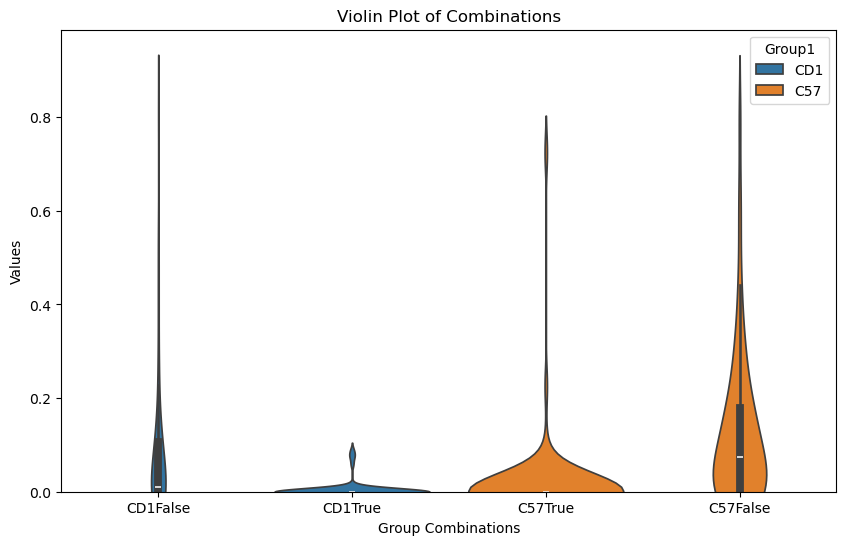

In [22]:
master_df['group'] = master_df['Strain'] + master_df['Is winner'].astype(str)
plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='Retreat (passive) % Time', data=master_df, hue='Strain', split=False)
plt.title('Violin Plot of Combinations')
plt.xlabel('Group Combinations')
plt.ylabel('Values')
plt.ylim(0)
plt.legend(title='Group1')
plt.show()

In [8]:
pilot3_df= master_df[master_df['Pilot'] == 3]
CD1_df = master_df[master_df['Strain']== 'CD1']
C57_df = master_df[master_df['Strain'] == 'C57']
losers_CD1_df = master_df[(master_df['Strain'] == 'CD1') & (master_df['Is loser'])]
losers_C57_df = master_df[(master_df['Strain'] == 'C57') & (master_df['Is loser'])]

winners_CD1_df = master_df[(master_df['Strain'] == 'CD1') & (master_df['Is winner'])]
winners_C57_df = master_df[(master_df['Strain'] == 'C57') & (master_df['Is winner'])]

rank1_CD1_df = master_df[(master_df['Strain'] == 'CD1') & (master_df['Rank'] == 1 )]
rank1_C57_df = master_df[(master_df['Strain'] == 'C57') & (master_df['Rank']== 1)]

rank4_CD1_df = master_df[(master_df['Strain'] == 'CD1') & (master_df['Rank'] == 4 )]
rank4_C57_df = master_df[(master_df['Strain'] == 'C57') & (master_df['Rank']== 4)]

# winners_CD1_df.to_excel(writer, sheet_name = 'CD1 Winners', index=True)
# winners_C57_df.to_excel(writer, sheet_name = 'C57 Winners', index=True)
# losers_CD1_df.to_excel(writer, sheet_name = 'CD1 Losers', index=True)
# losers_C57_df.to_excel(writer, sheet_name = 'C57 Losers', index=True)

In [10]:
ttest_dict = {}

for column in CD1_df.columns.to_list():
    column_dict = {}
    try: 
        t_statistics, p_value = stats.ttest_ind(CD1_df[column], C57_df[column])
        column_dict['T stats'] = t_statistics
        column_dict['p value'] = p_value
    except TypeError:
        pass
    ttest_dict[column] = column_dict
ttest_df = pd.DataFrame(ttest_dict)
ttest_df = ttest_df.transpose()
ttest_df = ttest_df.dropna()
#ttest_df.to_excel(writer, sheet_name = 'T Tests All Data', index = True)

In [11]:
sig_findings = ttest_df[ttest_df['p value'] < .05 ]
sig_findings

,T stats,p value
Resist Total time,3.213097,0.001468
Resist % Time,3.650472,0.000313
Resist Average Length of Bout,3.951705,0.000098
Push Total time,3.001656,0.002929
Push % Time,3.512945,0.000517
Push Average Length of Bout,3.790675,0.000184
Retreat (in contact) Number of events,-2.500483,0.012978
Retreat (in contact) Average Length of Bout,2.334305,0.020292
Retreat (passive) Number of events,-2.775422,0.005887


In [13]:
loser_ttest_dict = {}
for column in CD1_df.columns.to_list():
    column_dict = {}
    try: 
        t_statistics, p_value = stats.ttest_ind(losers_CD1_df[column], losers_C57_df[column])
        column_dict['T stats'] = t_statistics
        column_dict['p value'] = p_value
    except TypeError:
        pass
    loser_ttest_dict[column] = column_dict
loser_ttest_df = pd.DataFrame(loser_ttest_dict)
loser_ttest_df = loser_ttest_df.transpose()
loser_ttest_df = loser_ttest_df.dropna()
#loser_ttest_df.to_excel(writer, sheet_name = 'T Tests Losers only', index = True)



C:\Users\megha\AppData\Local\Temp\ipykernel_9540\1842501505.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistics, p_value = stats.ttest_ind(losers_CD1_df[column], losers_C57_df[column])


In [10]:
rank1_ttest_dict = {}
for column in CD1_df.columns.to_list():
    column_dict = {}
    try: 
        t_statistics, p_value = stats.ttest_ind(rank1_CD1_df[column], rank1_C57_df[column])
        column_dict['T stats'] = t_statistics
        column_dict['p value'] = p_value
    except TypeError:
        pass
    rank1_ttest_dict[column] = column_dict
rank1_ttest_df = pd.DataFrame(rank1_ttest_dict)
rank1_ttest_df = rank1_ttest_df.transpose()
rank1_ttest_df = rank1_ttest_df.dropna()
rank1_ttest_df.to_excel(writer, sheet_name = 'T Tests Rank 1 only', index = True)

C:\Users\megha\AppData\Local\Temp\ipykernel_6956\3116775236.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistics, p_value = stats.ttest_ind(rank1_CD1_df[column], rank1_C57_df[column])


In [11]:
rank4_ttest_dict = {}
for column in CD1_df.columns.to_list():
    column_dict = {}
    try: 
        t_statistics, p_value = stats.ttest_ind(rank4_CD1_df[column], rank4_C57_df[column])
        column_dict['T stats'] = t_statistics
        column_dict['p value'] = p_value
    except TypeError:
        pass
    rank4_ttest_dict[column] = column_dict
rank4_ttest_df = pd.DataFrame(rank4_ttest_dict)
rank4_ttest_df = rank4_ttest_df.transpose()
rank4_ttest_df = rank4_ttest_df.dropna()
rank4_ttest_df.to_excel(writer, sheet_name = 'T Tests Rank 4 only', index = True)

C:\Users\megha\AppData\Local\Temp\ipykernel_6956\3834133545.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistics, p_value = stats.ttest_ind(rank4_CD1_df[column], rank4_C57_df[column])


In [12]:
sig_findings = loser_ttest_df[loser_ttest_df['p value'] < .05 ]
sig_findings

,T stats,p value
Resist Total time,2.134181,0.034558
Resist % Time,2.211786,0.028591
Resist Average Length of Bout,2.709982,0.007564
Push Total time,2.458220,0.015175
Push % Time,3.141053,0.002052
Push Average Length of Bout,2.847763,0.005062
Retreat (in contact) Number of events,-2.374607,0.018914
Retreat (in contact) Average Length of Bout,2.547866,0.011910
Retreat (passive) Total time,-2.134484,0.034533
Retreat (passive) Number of events,-3.147142,0.002012


In [13]:
winner_ttest_dict = {}
for column in CD1_df.columns.to_list():
    column_dict = {}
    try: 
        t_statistics, p_value = stats.ttest_ind(winners_CD1_df[column], winners_C57_df[column])
        column_dict['T stats'] = t_statistics
        column_dict['p value'] = p_value
    except TypeError:
        pass
    winner_ttest_dict[column] = column_dict
winner_ttest_df = pd.DataFrame(winner_ttest_dict)
winner_ttest_df = winner_ttest_df.transpose()
winner_ttest_df = winner_ttest_df.dropna()
winner_ttest_df.to_excel(writer, sheet_name = 'T Tests winners only', index = True)

C:\Users\megha\AppData\Local\Temp\ipykernel_6956\3255891337.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistics, p_value = stats.ttest_ind(winners_CD1_df[column], winners_C57_df[column])


In [14]:
writer.save()

C:\Users\megha\AppData\Local\Temp\ipykernel_6956\934276808.py:1: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


[Text(1, 0, 'Push'),
 Text(2, 0, 'Resist'),
 Text(3, 0, 'Retreat\nin contact'),
 Text(4, 0, 'Retreat\npassive')]

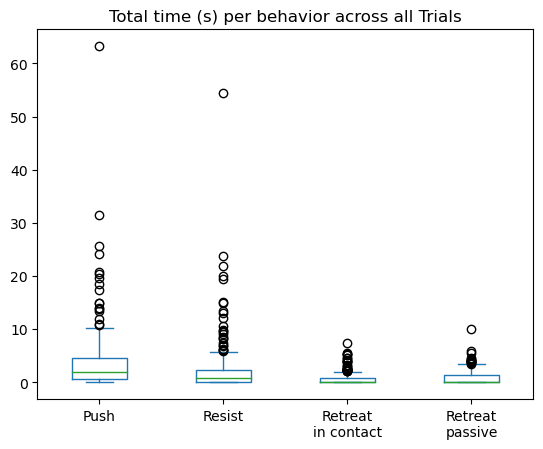

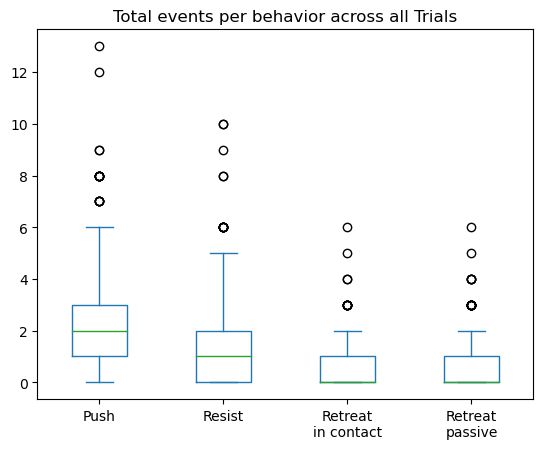

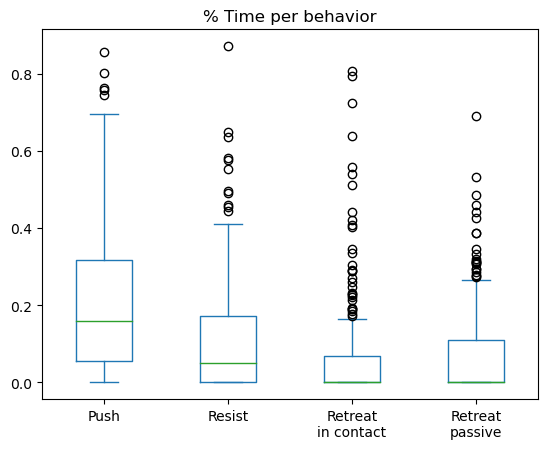

In [15]:

fig1 = master_df[['Push Total time', 
           'Resist Total time', 
           'Retreat (passive) Total time', 
           'Retreat (in contact) Total time']].plot.box()

fig1.set_title('Total time (s) per behavior across all Trials')
fig1.set_xticklabels(['Push', 'Resist', 'Retreat\nin contact', 'Retreat\npassive'])

fig2 = master_df[['Push Number of events', 
           'Resist Number of events', 
           'Retreat (passive) Number of events', 
           'Retreat (in contact) Number of events']].plot.box()
fig2.set_title('Total events per behavior across all Trials')
fig2.set_xticklabels(['Push', 'Resist', 'Retreat\nin contact', 'Retreat\npassive'])

box_plot = master_df[['Push % Time', 
           'Resist % Time', 
           'Retreat (passive) % Time', 
           'Retreat (in contact) % Time']].plot.box()
box_plot.set_title('% Time per behavior')
box_plot.set_xticklabels(['Push', 'Resist', 'Retreat\nin contact', 'Retreat\npassive'])

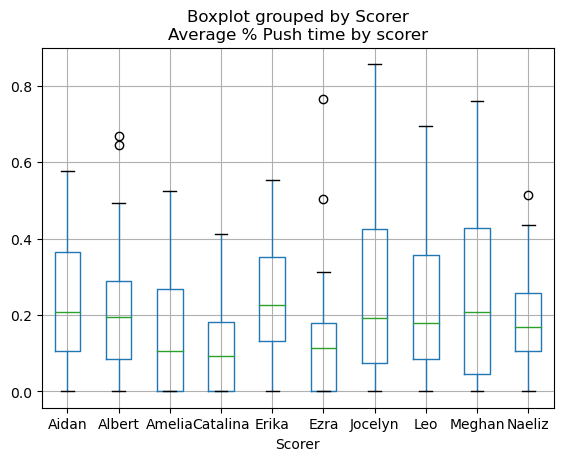

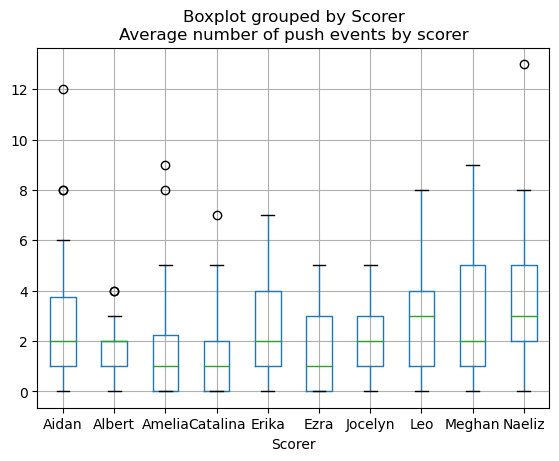

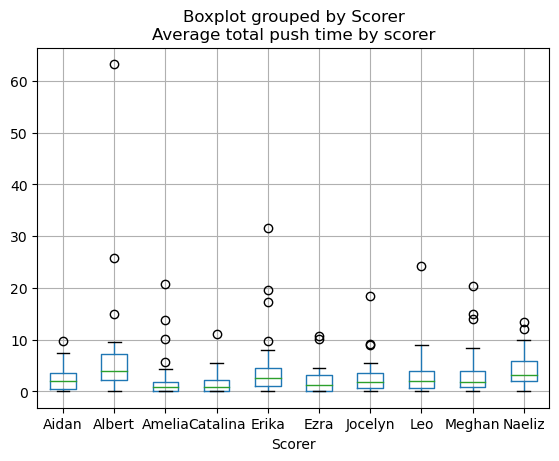

In [16]:
push_plot = master_df.boxplot(column = 'Push % Time', by = 'Scorer')
push_plot.set_title('Average % Push time by scorer')

plt2 = master_df.boxplot(column = 'Push Number of events', by = 'Scorer')
plt2.set_title('Average number of push events by scorer')

plt3 = master_df.boxplot(column = 'Push Total time', by = 'Scorer')
plt3.set_title('Average total push time by scorer')
plt.show()

NameError: name 'resisit_CD1' is not defined

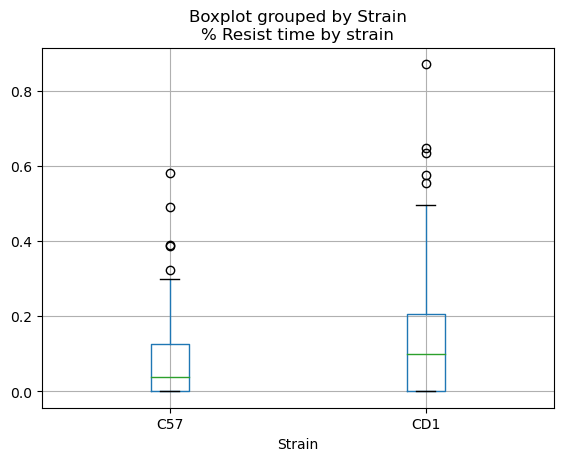

In [17]:
resist_strain = master_df.boxplot(column = 'Resist % Time', by = 'Strain')
resist_strain.set_title("% Resist time by strain")
resist_CD1 = CD1_df['Resist % Time']
resist_C57 = C57_df['Resist % Time']
print(t_statistics, p_value = stats.ttest_ind(resisit_CD1, resist_C57))

master_df.boxplot(column = 'Push % Time', by = 'Strain')
push_CD1 = CD1_df['Push % Time']


losers_passive = master_df[master_df['Is loser']== True].boxplot(column = 'Retreat (passive) % Time', by = 'Strain')
losers_passive.set_title('Retreat passive - Losers only')
retreat_p_CD1 = CD1_df['']

losers_incontact = master_df[master_df['Is loser']== True].boxplot(column = 'Retreat (in contact) % Time', by = 'Strain')
losers_incontact.set_title('Retreat in contact Losers only')

In [ ]:
loser_push_plot = master_df[master_df['Is loser']== False].boxplot(column = 'Push % Time', by = 'Strain')
loser_push_plot.set_title('Push % Time winners only')

In [ ]:
master_df[master_df['Is loser']== True].boxplot(column = 'Retreat (in contact) % Time', by = 'Loser Rank')

In [ ]:
master_df[master_df['Is loser']== True].boxplot(column = 'Retreat (passive) % Time', by = 'Loser Rank')

In [ ]:
master_df[(master_df['Is loser'] == True) & ( master_df['Day'].astype(str) != '1')].boxplot(column = 'Retreat (in contact) % Time', by = 'Winner Rank')

In [ ]:
master_df[(master_df['Is loser'] == True) & ( master_df['Day'].astype(str) != '1')].boxplot(column = 'Retreat (passive) % Time', by = 'Winner Rank')

In [ ]:
master_df[(master_df['Is loser'] == False) & ( master_df['Day'].astype(str) == 'stable') |( master_df['Strain'] == 'C57')].boxplot(column = 'Push % Time', by = 'Winner Rank')

In [ ]:
master_df[(master_df['Is loser'] == False) & ( master_df['Day'].astype(str) == 'stable') |( master_df['Strain'] == 'CD1')].boxplot(column = 'Push % Time', by = 'Winner Rank')

In [ ]:
master_df[(master_df['Is loser'] == True) & ( master_df['Rank Difference'].astype(int) >= 2)].boxplot(column = 'Trial Length ', by = 'Strain')

In [ ]:
master_df[(master_df['Is loser'] == True) & ( master_df['Rank Difference'].astype(int) < 2)].boxplot(column = 'Trial Length ', by = 'Strain')

In [ ]:
pilot3_df[(pilot3_df['Is loser'] == True) & ( pilot3_df['Rank Difference'].astype(int) < 2)].boxplot(column = 'Trial Length ', by = 'Strain')

In [ ]:
pilot3_df[(pilot3_df['Is loser'] == True) & ( pilot3_df['Rank Difference'].astype(int) >= 2)].boxplot(column = 'Trial Length ', by = 'Strain')

In [ ]:
pilot3_df.boxplot(column = 'Push % Time', by = 'Strain')

In [ ]:
pilot3_df.boxplot(column = 'Resist % Time', by = 'Strain')

In [ ]:
pilot3_df[(pilot3_df['Is loser'] == True) & ( pilot3_df['Strain'] == 'C57')].boxplot(column = 'Push % Time', by = 'Winner Rank')

In [ ]:
pilot3_df[(pilot3_df['Is loser'] == True) & ( pilot3_df['Strain'] == 'CD1')].boxplot(column = 'Push % Time', by = 'Winner Rank')

In [ ]:
pilot3_df[(pilot3_df['Rank Difference'] >= 2) & ( pilot3_df['Strain'] == 'CD1')].boxplot(column = 'Retreat (in contact) % Time', by = 'Winner Rank')

In [ ]:
pilot3_df[(pilot3_df['Is winner'] == False) & ( pilot3_df['Strain'] == 'CD1')].boxplot(column = 'Retreat (in contact) % Time', by = 'Winner Rank')

In [ ]:
pilot3_df[(pilot3_df['Is winner'] == False) & ( pilot3_df['Strain'] == 'C57')].boxplot(column = 'Retreat (in contact) % Time', by = 'Winner Rank')

In [ ]:
pilot3_df[pilot3_df['Is winner'] == False].boxplot(column = 'Retreat (in contact) % Time', by = 'Strain')

In [ ]:
pilot3_df[pilot3_df['Is winner'] == False].boxplot(column = 'Retreat (passive) % Time', by = 'Strain')

In [ ]:
master_df


In [ ]:
master_df.columns.to_list()


In [ ]:
pca = PCA(n_components=2) 

behavior_df = master_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout']]

pca.fit(behavior_df)
behavior_t_pca = pca.transform(behavior_df)
behavior_t_pca_df = pd.DataFrame(behavior_t_pca)
#behavior_t_pca_df['color'] = master_df['Strain'].apply(lambda x: 'r' if x == 'CD1' else 'b')
behavior_t_pca_df['color'] = master_df['Is loser'].apply(lambda x: 'r' if x == True else 'b')
plt.scatter(behavior_t_pca[:, 0], behavior_t_pca[:, 1], c = behavior_t_pca_df['color'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

In [ ]:
behavior_t_pca

In [ ]:
pca = PCA(n_components=2) 

behavior_df = master_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout', 'Strain']]

CD1_behavior_df = behavior_df[behavior_df['Strain'] == 'CD1']
C57_behavior_df = behavior_df[behavior_df['Strain'] == 'C57']
CD1_behavior_df = CD1_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]
C57_behavior_df = C57_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]

pca.fit(CD1_behavior_df)
CD1_pca_t = pca.transform(CD1_behavior_df)
pca.fit(C57_behavior_df)
C57_pca_t = pca.transform(C57_behavior_df)

fig, ax = plt.subplots()
ax.scatter(CD1_pca_t[:, 0], CD1_pca_t[:, 1], c='blue', label='CD1')
ax.scatter(C57_pca_t[:, 0], C57_pca_t[:, 1], c='red', label='C57')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Scatter Plot')
plt.show()

In [ ]:
behavior_df = pilot3_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout', 'Strain']]

CD1_behavior_df = behavior_df[behavior_df['Strain'] == 'CD1']
C57_behavior_df = behavior_df[behavior_df['Strain'] == 'C57']
CD1_behavior_df = CD1_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]
C57_behavior_df = C57_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]

pca.fit(CD1_behavior_df)
CD1_pca_t = pca.transform(CD1_behavior_df)
pca.fit(C57_behavior_df)
C57_pca_t = pca.transform(C57_behavior_df)
plt.scatter(CD1_pca_t[:, 0], CD1_pca_t[:, 1], c='blue', label='CD1')
plt.scatter(C57_pca_t[:, 0], C57_pca_t[:, 1], c='red', label='C57')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

In [ ]:
rank1_df = master_df[master_df['Rank'] == 1]
rank1_df
behavior_df_1 = rank1_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout', 'Strain']]

CD1_behavior_df = behavior_df[behavior_df['Strain'] == 'CD1']
C57_behavior_df = behavior_df[behavior_df['Strain'] == 'C57']
CD1_behavior_df = CD1_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]
C57_behavior_df = C57_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]

rank4_df = master_df[master_df['Rank'] == 4]
rank4_df
behavior_df_4 = rank4_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout', 'Strain']]

CD1_behavior_df = behavior_df[behavior_df['Strain'] == 'CD1']
C57_behavior_df = behavior_df[behavior_df['Strain'] == 'C57']
CD1_behavior_df = CD1_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]
C57_behavior_df = C57_behavior_df[['Trial Length ','Resist Total time',
 'Resist Number of events',
 'Push Total time',
 'Push Number of events',
 'Retreat (in contact) Total time',
 'Retreat (in contact) Number of events',
 'Retreat (passive) Total time',
 'Retreat (passive) Number of events']]

In [ ]:
rank4_df = master_df[master_df['Rank'] == 4]
rank4_df
behavior_df_4 = rank4_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout']]


rank1_df = master_df[master_df['Rank'] == 1]
rank1_df
behavior_df_1 = rank1_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout']]


In [ ]:
pca.fit(behavior_df_1)
rank1_pca_t = pca.transform(behavior_df_1)
pca.fit(behavior_df_4)
rank4_pca_t = pca.transform(behavior_df_4)
plt.scatter(rank1_pca_t[:, 0], rank1_pca_t[:, 1], c='blue', label='rank1')
plt.scatter(rank4_pca_t[:, 0], rank4_pca_t[:, 1], c='red', label='rank4')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

In [ ]:
loser_df = master_df[master_df['Is loser'] == True]
loser_df
behavior_df_loser = loser_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout']]


winner_df = master_df[master_df['Is winner'] == True]
winner_df
behavior_df_winner = winner_df[['Trial Length ','Resist Total time',
 'Resist % Time',
 'Resist Number of events',
 'Resist Average Length of Bout',
 'Push Total time',
 'Push % Time',
 'Push Number of events',
 'Push Average Length of Bout',
 'Retreat (in contact) Total time',
 'Retreat (in contact) % Time',
 'Retreat (in contact) Number of events',
 'Retreat (in contact) Average Length of Bout',
 'Retreat (passive) Total time',
 'Retreat (passive) % Time',
 'Retreat (passive) Number of events',
 'Retreat (passive) Average Length of Bout']]

In [ ]:
pca.fit(behavior_df_winner)
winner_pca_t = pca.transform(behavior_df_winner)
pca.fit(behavior_df_loser)
loser_pca_t = pca.transform(behavior_df_loser)
plt.scatter(winner_pca_t[:, 0], winner_pca_t[:, 1], c='blue', label='winner')
plt.scatter(loser_pca_t[:, 0], loser_pca_t[:, 1], c='red', label='loser')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()